In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.collab import *
from fastai.tabular import *

import pandas as pd
import numpy as np

In [3]:
user,it,title = 'userId','movieId','movie title'

In [4]:
u_cols = ["userId","movieId", "rating", "timestamp"]
dat = pd.read_csv('u.data', sep='\t', names=u_cols,
                    encoding='latin-1')

In [5]:
dat.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
dat.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [7]:
item_cols = ['movieId', 'movie title', 'release date', 'video release date',
             'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 
             "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
             'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
             'Thriller', 'War', 'Western']
item = pd.read_csv('u.item', sep='|', names=item_cols,
                    encoding='latin-1')

In [8]:
item.head()

,movieId,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
dat.drop(columns = 'timestamp', inplace=True)

In [10]:
dataf = dat.merge(item[[it ,title]], on='movieId')
dataf.tail()

,userId,movieId,rating,movie title
99995,840,1674,4,Mamma Roma (1962)
99996,655,1640,3,"Eighth Day, The (1996)"
99997,655,1637,3,Girls Town (1996)
99998,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1..."
99999,655,1641,3,Dadetown (1995)


`CollabDataBunch` is a custom Pytorch Dataset of the fastai library which is used for collaborative filtering (child class of `DataBunch`). This splits the dataset into training and validation sets based on `valid_pct` and uses the DataLoader pytorch class to create batches of 64 (default)

In [11]:
data = CollabDataBunch.from_df(dataf, seed=42, valid_pct=0.1, item_name=title)

In [12]:
data.show_batch()

userId,movie title,target
394,Last Action Hero (1993),4.0
233,Jurassic Park (1993),4.0
481,Indiana Jones and the Last Crusade (1989),4.0
146,Liar Liar (1997),1.0
594,Jerry Maguire (1996),3.0


Even though the range of possible ratings is `0.5 to 5`, I've set it from `0 to 5.5` because the activation function is a sigmoid function, where the border values are asymptotic, and thus we'll never be able to predict border values unless the model is infinitely certain about it

In [13]:
y_range = [0,5.5]

In [14]:
def collab_learner(data, n_factors=None, use_nn=False, emb_szs=None, layers=None, 
                   ps=None, emb_drop=0., y_range=None, use_bn=True, 
                   bn_final=False, **learn_kwargs):
    "Create a Learner for collaborative filtering on `data`."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    u,m = data.train_ds.x.classes.values()
    if use_nn: model = EmbeddingNN(emb_szs=emb_szs, layers=layers, ps=ps, emb_drop=emb_drop, y_range=y_range, 
                                   use_bn=use_bn, bn_final=bn_final, **learn_kwargs)
    else:      model = EmbeddingDotBias(n_factors, len(u), len(m), y_range=y_range)
    return CollabLearner(data, model, **learn_kwargs)

The `collab_learner` creates a an embedding matrix of `n_factors` weights and a bias for both the users and the items. The resultant neuron is a sum of dot product of the corresponding weights in user and item, and the biases, which is them passed through a sigmoid activation function. The collab learner then uses Stochastic Gradient Descent to optimize the Embeddings matrix and create meaningful predictions

In [15]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

Here, I used the Learning Rate finder method of fast.ai to find an appropriate learning rate for training the neural net. The rule of thumb used to determine a good learning rate is to use the point where the decrease is loss is the steepest w.r.t. the learning rate before it diverges, and divide the result by 10

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


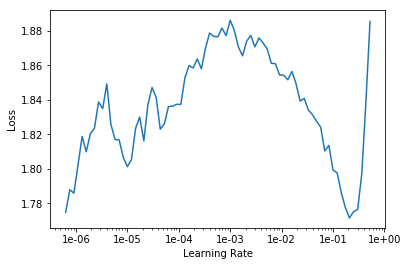

In [16]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

The `fit_one_cycle` learner in the fastai library varies the learning rate from batch to batch, starting with a low learning rate, which gradually increases to a maximum learning rate (5e-3 in this case). This is an efficient technique to converge the model to the minimum of loss in the least possible number of epochs

In [17]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.936571,0.948434,00:07
1,0.857685,0.887667,00:07
2,0.762996,0.830198,00:07
3,0.667109,0.813467,00:07
4,0.581939,0.813297,00:07


In [18]:
learn.show_results(ds_type=DatasetType.Valid)

userId,movie title,target,prediction
498,Casino (1995),3.0,3.5572147
642,Pocahontas (1995),5.0,3.2678304
58,2001: A Space Odyssey (1968),4.0,4.148956
495,Cat People (1982),3.0,3.6517959
618,Philadelphia (1993),3.0,3.188271
